In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

I0207 124934.648 _utils_internal.py:234] NCCL_DEBUG env var is set to None


I0207 124934.648 _utils_internal.py:252] NCCL_DEBUG is forced to WARN from None


I0207 124936.859 font_manager.py:1349] generated new fontManager


In [2]:
# load data

words = open("/home/yucongguo/names.txt", "r").read().splitlines()
print(words[:8])
print(f"length of words = {len(words)}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
length of words = 32033


In [3]:
# build the vocabulary of characters and mapping to/from integers

char = sorted(list(set(''.join(words))))
str_to_int = {string: index+1 for index, string in enumerate(char)}
str_to_int['.'] = 0
int_to_str = {index+1: string for index, string in enumerate(char)}
int_to_str[0] = '.'
print(f"str_to_int : {str_to_int}")
print(f"int_to_str : {int_to_str}")

str_to_int : {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
int_to_str : {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    #input: list of wards
    #output: X,Y

    x = []
    y = []
    for w in words:
        context = [0] * block_size #assume all word start with "..."
        for character in w+'.':
            next_char_index = str_to_int[character]
            x.append(context)
            y.append(next_char_index)
            context = context[1:] + [next_char_index]

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train,y_train = build_dataset(words[:n1])
x_val,y_val = build_dataset(words[n1:n2])
x_test,y_test = build_dataset(words[n2:])

print(f"x_train shape : {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape : {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape : torch.Size([182625, 3]), y_train shape: torch.Size([182625])
x_val shape : torch.Size([22655, 3]), y_val shape: torch.Size([22655])
x_test shape : torch.Size([22866, 3]), y_test shape: torch.Size([22866])


## implement module

In [5]:
#define DNN module

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training: # use in training
            x_mean = x.mean(0, keepdim = True) # batch mean
            x_var = x.var(0, keepdim = True) # batch variance
        else: # use in testing
            x_mean = self.running_mean
            x_var = self.running_var 
        
        x_normalized = (x-x_mean) / torch.sqrt(x_var + self.eps) # normalize x
        self.out = self.gamma * x_normalized + self.beta #scale and shift. need to learn gamma and beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

## basic MLP model

In [6]:
# MLP model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(str_to_int)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True


max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch
    ix = torch.randint(0,x_train.shape[0], (batch_size,))
    x_train_batch, y_train_batch = x_train[ix], y_train[ix]

    #forward pass
    emb = C[x_train_batch]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_train_batch)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i <150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 3.3240


  10000/  50000: 2.1163


  20000/  50000: 2.2687


  30000/  50000: 2.2345


  40000/  50000: 2.0457


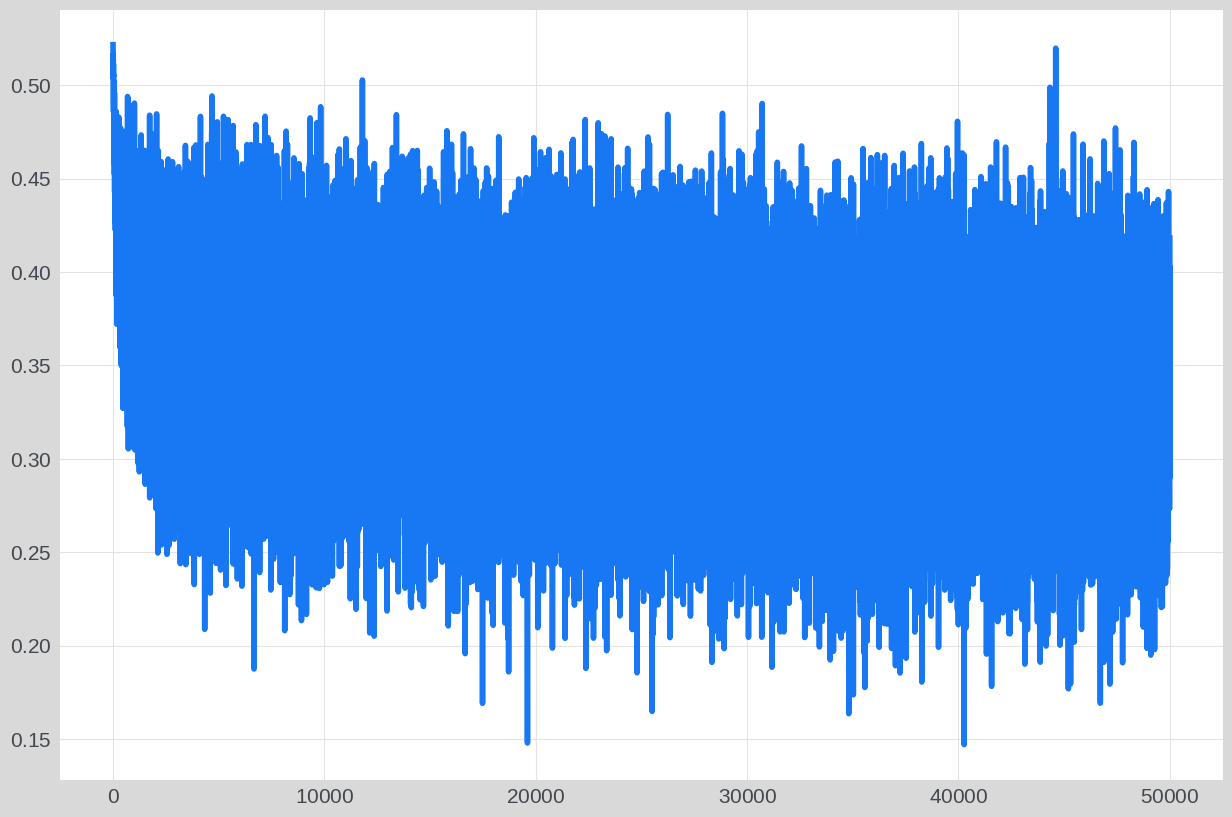

In [7]:
plt.plot(lossi)

In [8]:
# evaluate the model

# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0965311527252197
val 2.141301155090332


## fix the loss plot

current the loss plot does not make sense, need to refine the lossi


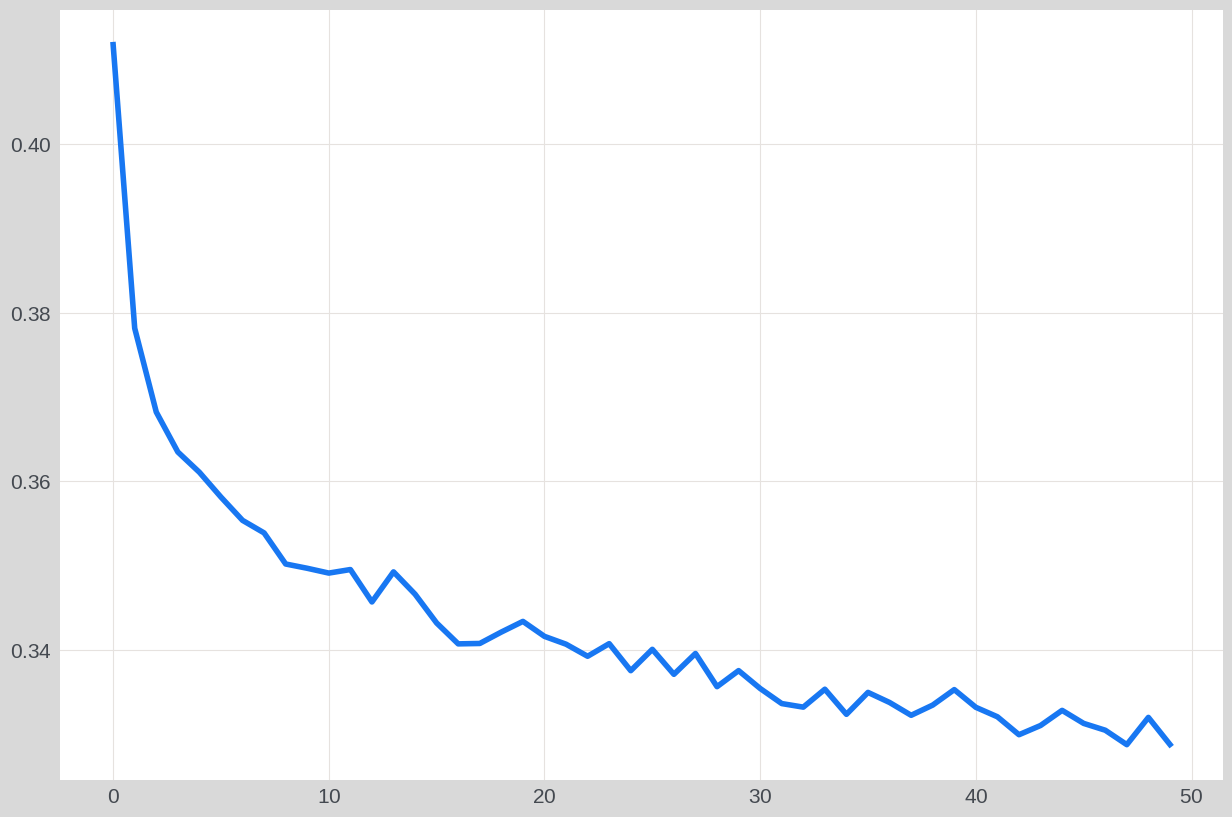

In [9]:
print("current the loss plot does not make sense, need to refine the lossi")
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # for each 1000 steps, average over the 1000 losses


## creating pytorch like module and model

previous model still have hand implemented word embedding layer
and model take too much steps

In [10]:
#define DNN module

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training: # use in training
            x_mean = x.mean(0, keepdim = True) # batch mean
            x_var = x.var(0, keepdim = True) # batch variance
        else: # use in testing
            x_mean = self.running_mean
            x_var = self.running_var 
        
        x_normalized = (x-x_mean) / torch.sqrt(x_var + self.eps) # normalize x
        self.out = self.gamma * x_normalized + self.beta #scale and shift. need to learn gamma and beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters (self):
        return [p for layer in self.layers for p in layer.parameters()]


In [11]:
# MLP model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(str_to_int)
block_size = 3 

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])



with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True


#train model
max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch
    ix = torch.randint(0,x_train.shape[0], (batch_size,))
    x_train_batch, y_train_batch = x_train[ix], y_train[ix]

    #forward pass
    logits = model(x_train_batch)
    loss = F.cross_entropy(logits, y_train_batch)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i <150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 3.8399


  10000/  50000: 2.0494


  20000/  50000: 2.1513


  30000/  50000: 2.3244


  40000/  50000: 2.1027


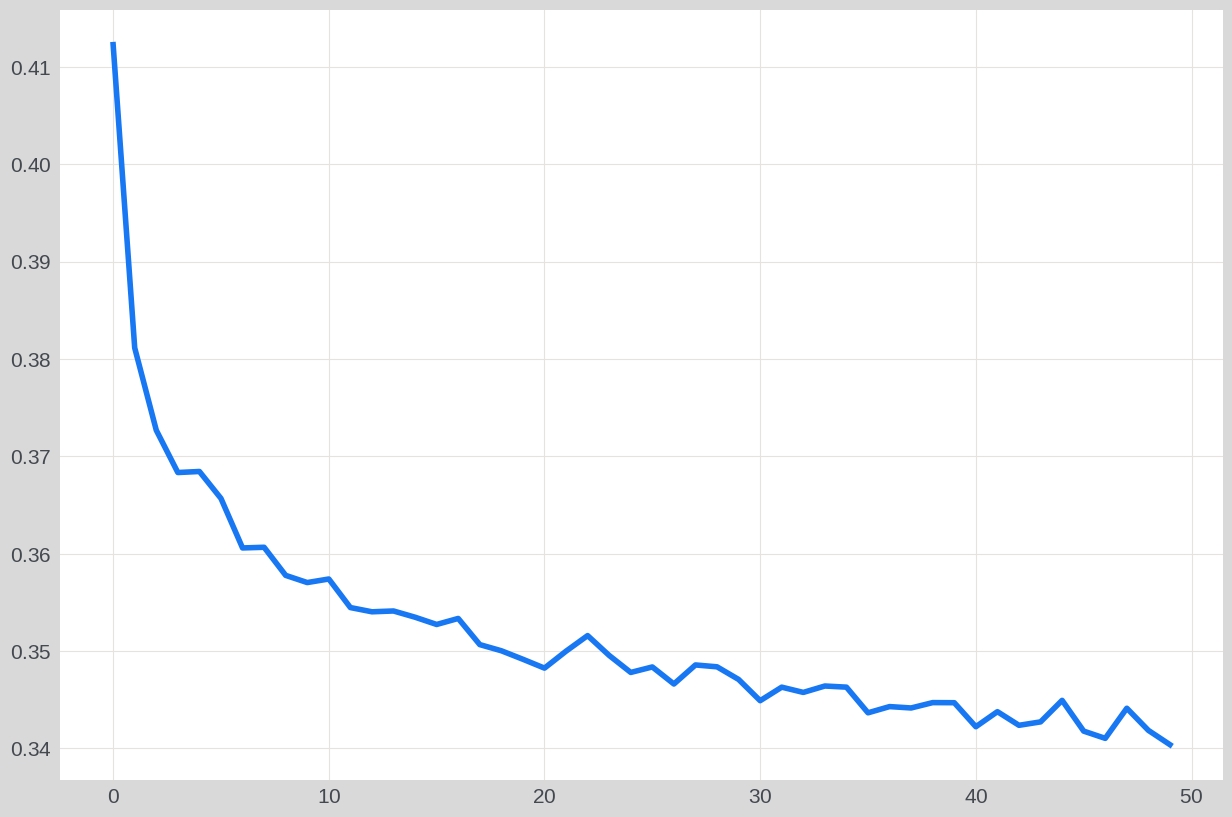

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # for each 1000 steps, average over the 1000 losses


In [13]:
# evaluate the model

for layer in model.layers:
    layer.training = False

@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1614573001861572
val 2.178663730621338


In [14]:
#sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size #initialization
    while True:
    #forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0 :
            break
    print(''.join(int_to_str[i] for i in out))

tehimanei.
wrianay.
reigh.
syah.
mare.
dan.
cshani.
anmett.
sap.
keelam.
jediya.
avel.
adreyah.
sest.
audond.
wri.
basahristalyn.
una.
ski.
naigo.


# WaveNet

https://arxiv.org/abs/1609.03499 \
STACK OF DIALATED CAUSAL CONVOLUTION LAYER

In [15]:
# build the dataset, take 8 characters to make prediction

block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    #input: list of wards
    #output: X,Y

    x = []
    y = []
    for w in words:
        context = [0] * block_size #assume all word start with "..."
        for character in w+'.':
            next_char_index = str_to_int[character]
            x.append(context)
            y.append(next_char_index)
            context = context[1:] + [next_char_index]

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train,y_train = build_dataset(words[:n1])
x_val,y_val = build_dataset(words[n1:n2])
x_test,y_test = build_dataset(words[n2:])

print(f"x_train shape : {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape : {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape : torch.Size([182580, 8]), y_train shape: torch.Size([182580])
x_val shape : torch.Size([22767, 8]), y_val shape: torch.Size([22767])
x_test shape : torch.Size([22799, 8]), y_test shape: torch.Size([22799])


In [16]:
# wavenet toy example illustration

ix = torch.randint(0, x_train.shape[0], (4,)) 
x_train_batch, y_train_batch = x_train[ix], y_train[ix]
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])
logits = model(x_train_batch)
print(f"size of minibatch traning data: {x_train_batch.shape}\n")
print(f"x_train_batch:\n{x_train_batch}\n")
print(f"output of embedding layer: {model.layers[0].out.shape}\n")
print(f"output of flatten layer: {model.layers[1].out.shape}\n")
print(f"output of linear layer: {model.layers[2].out.shape}\n")
print("in linear layer, we are doing (4,80) @ (80,100) matrix multiplication,")
print("but in wavenet, we only want to flatten 2 character not 8, (1 2)(3 4)(5 6)(7 8)")
print("ie: (4,2,20) * (20,200) = (4,2,200) matrix multiplication\n")
print("therefore, we need to change flattern layer\n")

print("example code:")
print("e = torch.randn(4,8,10)")
e = torch.randn(4,8,10)
print("torch.cat([e[:,::2,:],e[:,1::2,:]],dim = 2).shape")
print(torch.cat([e[:,::2,:],e[:,1::2,:]],dim = 2).shape)

size of minibatch traning data: torch.Size([4, 8])

x_train_batch:
tensor([[ 0,  0,  0,  7,  9, 12, 19, 15],
        [ 0,  0,  0,  0, 22,  9, 11, 20],
        [ 0, 18, 15,  3, 11, 12, 25, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

output of embedding layer: torch.Size([4, 8, 10])

output of flatten layer: torch.Size([4, 80])

output of linear layer: torch.Size([4, 100])

in linear layer, we are doing (4,80) @ (80,100) matrix multiplication,
but in wavenet, we only want to flatten 2 character not 8, (1 2)(3 4)(5 6)(7 8)
ie: (4,2,20) * (20,200) = (4,2,200) matrix multiplication

therefore, we need to change flattern layer

example code:
e = torch.randn(4,8,10)
torch.cat([e[:,::2,:],e[:,1::2,:]],dim = 2).shape
torch.Size([4, 4, 20])


In [17]:
# define DNN module
# add class FlattenConsecutive
# fixed class BatchNorm1d to handel 3 dim input
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training: # use in training
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = x.mean(dim, keepdim = True) # batch mean
            x_var = x.var(dim, keepdim = True) # batch variance
        else: # use in testing
            x_mean = self.running_mean
            x_var = self.running_var 
        
        x_normalized = (x-x_mean) / torch.sqrt(x_var + self.eps) # normalize x
        self.out = self.gamma * x_normalized + self.beta #scale and shift. need to learn gamma and beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n #numer of consecutive character
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters (self):
        return [p for layer in self.layers for p in layer.parameters()]


In [27]:
# MLP model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(str_to_int)
block_size = 8 

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])



with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True


#train model
max_steps = 50000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch
    ix = torch.randint(0,x_train.shape[0], (batch_size,))
    x_train_batch, y_train_batch = x_train[ix], y_train[ix]

    #forward pass
    logits = model(x_train_batch)
    loss = F.cross_entropy(logits, y_train_batch)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i <150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 3.5904


  10000/  50000: 2.0918


  20000/  50000: 2.1277


  30000/  50000: 2.1338


  40000/  50000: 2.4058


In [22]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 100)
BatchNorm1d : (32, 4, 100)
Tanh : (32, 4, 100)
FlattenConsecutive : (32, 2, 200)
Linear : (32, 2, 100)
BatchNorm1d : (32, 2, 100)
Tanh : (32, 2, 100)
FlattenConsecutive : (32, 200)
Linear : (32, 100)
BatchNorm1d : (32, 100)
Tanh : (32, 100)
Linear : (32, 27)


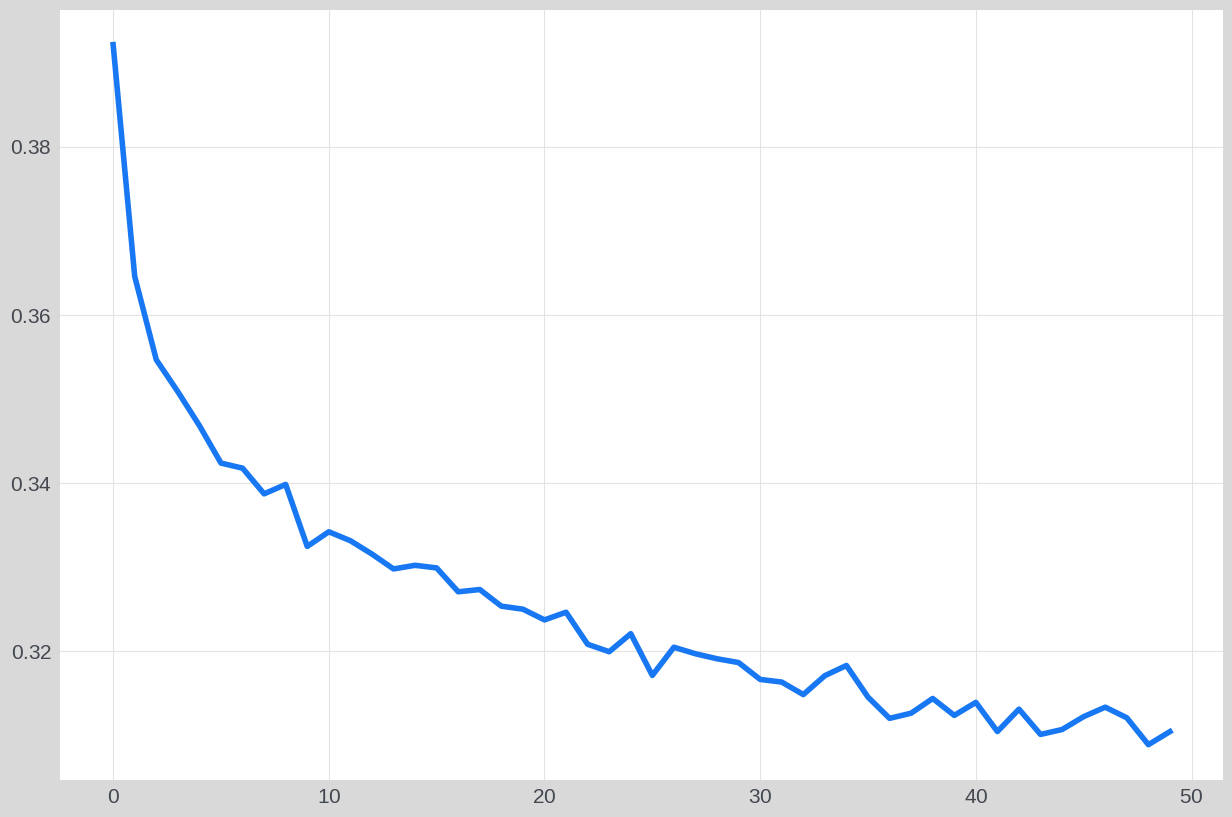

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # for each 1000 steps, average over the 1000 losses



In [24]:
# evaluate the model

for layer in model.layers:
    layer.training = False

@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0214149951934814
val 2.0804455280303955


In [26]:
#sample from the model

for _ in range(20):
    out = []
    context = [0] * 8 #initialization
    while True:
    #forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0 :
            break
    print(''.join(int_to_str[i] for i in out))

bressefin.
evonaevious.
hoster.
marika.
liza.
chostina.
pajon.
grethalycy.
farian.
annlee.
sof.
herly.
cashailiah.
janora.
kenslee.
gehad.
harlana.
zena.
yonabn.
dalynly.
